In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, signal, optimize
import sed_fitting as sed
import LC_funcs as lc_func

import emcee
import corner
from multiprocessing import Pool

import os
os.environ['OMP_NUM_THREADS']='1'
os.nice(19)

19

In [2]:
wlmin=3000
wlmax=300000

wl_grid1 = np.arange(wlmin, wlmax, 0.1)
wl_grid2 = np.arange(wlmin, wlmax, 10)

t_grids = np.arange(2600,3600,100)
g_grids = np.array([4.0, 4.5, 5.0, 5.5])
m_grids = np.array([-0.5, 0.0, 0.3, 0.5])

nt = len(t_grids)
ng = len(g_grids)
nm = len(m_grids)

print(nt, ng, nm)

10 4 4


In [3]:
%%time

window = np.ones(100) / 100

spec_bin = {}
a=0

for i in range(nt):
    for j in range(ng):
        for k in range(nm):
            
            label = '{0:d}-{1:.1f}-{2:.1f}'.format(t_grids[i], g_grids[j], m_grids[k])
            wl, spec = sed.load_bt_settl(t_grids[i], g_grids[j], m_grids[k], a)
            # wl: Angstrom
            # spec: erg cm^-2 s^-1 A^-1
            
            ## smoothing and interpolating for 0.1 Angstrom grids
            spec_savgol = signal.savgol_filter(spec, 3, 1)
            spec_func1 = interpolate.interp1d(wl, spec_savgol, kind='linear')
            spec_interp1 = spec_func1(wl_grid1)

            ## averaging and interpolating for 10 Angstrom grids            
            spec_moveave = np.convolve(spec_interp1, window, mode='same')
            spec_func2 = interpolate.interp1d(wl_grid1, spec_moveave, kind='linear')
            spec_interp2 = spec_func2(wl_grid2)
            
            spec_bin[label] = spec_interp2

CPU times: user 2min 14s, sys: 3.46 s, total: 2min 18s
Wall time: 2min 23s


CPU times: user 15.5 ms, sys: 2.3 ms, total: 17.8 ms
Wall time: 18.2 ms


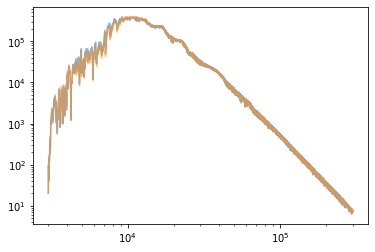

In [4]:
%%time

t = 3000
g = 4.5
m = 0.0
flux_intp = sed.interp_spectra_3D(t,g,m, spec_bin)
plt.plot(wl_grid2, flux_intp, alpha=0.5)

t = 3000
g = 4.9
m = 0.5
flux_intp = sed.interp_spectra_3D(t,g,m, spec_bin)
plt.plot(wl_grid2, flux_intp, alpha=0.5)

plt.xscale('log')
plt.yscale('log')

In [17]:
magfile = 'Magfiles/TOI-5671.csv'
band,mag,mage = np.genfromtxt(magfile, delimiter=',', skip_header=1, unpack=True, dtype=('<U4',float,float), usecols=(0,1,2))

mag_cat={}
mag_cat_err={}
#mage_floor = 0.01
mage_floor = 0.

for i in range(len(band)):
    mag_cat[band[i]] = mag[i]
    mag_cat_err[band[i]] = np.sqrt( mage[i]**2 + mage_floor**2 )

In [18]:
bands_cat = list(mag_cat.keys())
nband_cat = len(bands_cat)

trans=[]
zero_mag_flux=[]

flux_cat = np.zeros(nband_cat)
flux_cat_err = np.zeros(nband_cat)
wl_cen = np.zeros(nband_cat)

for i in range(nband_cat):
    if bands_cat[i]=='J' or bands_cat[i]=='H' or bands_cat[i]=='K':
        trans.append(sed.load_filter_response('2MASS', bands_cat[i], wl_grid2))
        zero_mag_flux.append(sed.zero_mag_flux('2MASS', bands_cat[i]))
        
    elif bands_cat[i]=='G' or bands_cat[i]=='BP' or bands_cat[i]=='RP':
        trans.append(sed.load_filter_response('Gaia', bands_cat[i], wl_grid2))
        zero_mag_flux.append(sed.zero_mag_flux('Gaia', bands_cat[i]))

    elif bands_cat[i]=='W1' or bands_cat[i]=='W2' or bands_cat[i]=='W3' or bands_cat[i]=='W4':
        trans.append(sed.load_filter_response('WISE', bands_cat[i], wl_grid2))
        zero_mag_flux.append(sed.zero_mag_flux('WISE', bands_cat[i]))

    flux_cat[i] = 10**(-0.4*mag_cat[bands_cat[i]]) * zero_mag_flux[i]
    flux_cat_err[i] = 0.4*np.log(10)*flux_cat[i]*mag_cat_err[bands_cat[i]]
    wl_cen[i] = np.sum(trans[i]*wl_grid2)/np.sum(trans[i])
    print(i, wl_cen[i], flux_cat[i], flux_cat_err[i])

0 6390.235967314677 9.880302708545262e-16 2.5480266258680822e-18
1 5182.576221055991 4.339083247456883e-16 2.302351020353771e-18
2 7825.080506091992 1.4908628692481353e-15 5.548840342828779e-18
3 12412.960507539668 1.5725539837629118e-15 4.055452084253788e-17
4 16513.59127770306 9.786556548175633e-16 2.073162888200668e-17
5 21655.55531016508 4.863490528047008e-16 1.0302712726614879e-17
6 33791.91321898688 1.051681606344895e-16 3.2933574895102716e-18
7 46292.96614728299 3.452368418189438e-17 1.0811145995135153e-18


In [7]:
Rsun = 6.96e8 # km
pc = 3.085677581e16 # m
GMsun = 1.32712440041e20 # m^3 s^-2

def log_like(p):
    
    t, rs, ms, m, d, log_jit = p
    
#    m = m_prior + np.random.randn(1)*m_prior_err
#    ms = ms_prior + np.random.randn(1)*ms_prior_err
    
    if t <= 2600 or t >= 3500:
        return -np.inf

    if m <= -0.5 or m >= 0.5:
        return -np.inf
    
    if rs <= 0 or d <= 0 or ms <= 0:
        return -np.inf
    
    if log_jit < -10 or log_jit > 10:
        return -np.inf
    
    logg = np.log10( GMsun*ms / (rs*Rsun)**2 *100 ) # cgs
    theta = rs*Rsun/(d*pc)
    pi = 1e3/d # mas

    if logg <= 4.0 or logg >= 5.5:
        return -np.inf

    jit = np.exp(log_jit)
    
    
    flux_intp = sed.interp_spectra_3D(t, logg, m, spec_bin)
    
    log_like = 0
    for i in range(nband_cat):
        
        flux_model = theta**2 *\
            np.sum(wl_grid2*flux_intp*trans[i])/np.sum(wl_grid2*trans[i])

        flux_cat_err2 = (0.4*np.log(10)*flux_cat[i])**2\
                            *(mag_cat_err[bands_cat[i]]**2 +jit**2)
        
        log_like += -0.5*(flux_cat[i] -flux_model)**2 / flux_cat_err2\
                    -0.5*np.log(2*np.pi*flux_cat_err2)
        
#    log_like += -0.5*(t - t_prior)**2/t_prior_err**2
    log_like += -0.5*(m - m_prior)**2/m_prior_err**2
    log_like += -0.5*(ms - ms_prior)**2/ms_prior_err**2
#    log_like += -0.5*(rs - rs_prior)**2/rs_prior_err**2
    log_like += -0.5*(pi - pi_prior)**2/pi_prior_err**2
        
    return log_like

In [8]:
def neg_log_like(p):
    return -log_like(p)

In [9]:
p0 = [3300, 0.4, 0.4, -0.2, 10, -5]
print(len(p0))

## for TOI-5671

m_prior = -0.20
m_prior_err = 0.50

# m_prior = 0
# m_prior_err = 0.01


## from emp. relations (no Fe/H prior)
ms_prior = 0.3956 
ms_prior_err = 0.0089 * 5
# rs_prior = 0.4036 
# rs_prior_err = 0.0122

## from IRD
# t_prior = 3339
# t_prior_err = 43

## from GaiaDR3
pi_prior = 6.0742
pi_prior_err = 0.0348


res = optimize.minimize(neg_log_like, p0, method='Nelder-Mead')

for i in range(5):
    res = optimize.minimize(neg_log_like, res.x, method='Nelder-Mead')

print(res)

6
 final_simplex: (array([[ 2.81136418e+03,  7.79046398e-08,  6.81581543e-15,
        -1.99999944e-01,  1.64630733e+02,  7.96141964e-02],
       [ 2.81136418e+03,  7.79046398e-08,  6.81581527e-15,
        -1.99999944e-01,  1.64630733e+02,  7.96141964e-02],
       [ 2.81136425e+03,  7.79046398e-08,  6.81581527e-15,
        -1.99999944e-01,  1.64630733e+02,  7.96141964e-02],
       [ 2.81136418e+03,  7.79046416e-08,  6.81581527e-15,
        -1.99999944e-01,  1.64630733e+02,  7.96141964e-02],
       [ 2.81136420e+03,  7.79046402e-08,  6.81581531e-15,
        -1.99999944e-01,  1.64630733e+02,  7.96141964e-02],
       [ 2.81136420e+03,  7.79046402e-08,  6.81581531e-15,
        -1.99999944e-01,  1.64630733e+02,  7.96141964e-02],
       [ 2.81136420e+03,  7.79046402e-08,  6.81581531e-15,
        -1.99999944e-01,  1.64630733e+02,  7.96141964e-02]]), array([-271.52907706, -271.52907706, -271.52907706, -271.52907706,
       -271.52907706, -271.52907706, -271.52907706]))
           fun: -271.5290

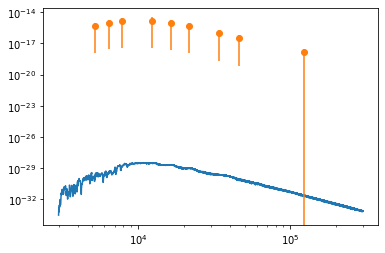

In [11]:
t, rs, ms, m, d, log_jit = res.x
        
# ms = ms_prior
# m = m_prior
logg = np.log10( GMsun*ms / (rs*Rsun)**2 *100 ) # cgs
theta = rs*Rsun/(d*pc)
pi = 1e3/d # mas

jit = np.exp(log_jit)

spec = sed.interp_spectra_3D(t, logg, m, spec_bin)

flux_cat_err=np.zeros(nband_cat)
for i in range(nband_cat):
    flux_cat_err[i] = 0.4*np.log(10)*flux_cat[i]\
                    *np.sqrt((mag_cat_err[bands_cat[i]]**2 +jit**2)) 

plt.plot(wl_grid2, spec*theta**2)
plt.errorbar(wl_cen, flux_cat, yerr=np.sqrt(flux_cat_err**2), fmt='o')
plt.xscale('log')
plt.yscale('log')

In [68]:
Lsun = 3.839e33 # erg/s
Rsun = 6.96e8 # m
#Rsun = 696000*1e2 # cm
Ltot = np.sum(10*spec) * 4*np.pi*(rs*Rsun*1e2)**2

Ltot/Lsun

0.0072455917181467955

In [12]:
%%time

ndim, nwalkers = len(p0), 30
pos = [res.x + 1e-5*np.random.randn(ndim) for i in range(nwalkers)]

nsteps = 10000

#filename = 'mcmc_tmp.hd5'
filename = 'mcmc_fit_sed_TOI-5671.hd5'
!rm -f $filename
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)


with Pool(12) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_like,\
                backend=backend, pool=pool, )
    sampler.run_mcmc(pos, nsteps, progress=True)


  0%|                                                 | 0/10000 [00:00<?, ?it/s]/ut3/afukui/miniconda3/envs/py38/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|█████████████████████████████████████| 10000/10000 [06:03<00:00, 27.54it/s]

CPU times: user 2min 41s, sys: 27.7 s, total: 3min 9s
Wall time: 6min 3s


In [19]:
samples = sampler.get_chain()
pos = samples[-1,:,:]

nsteps = 10000

filename = 'mcmc_fit_sed_TOI-5671.hd5'
!rm -f $filename
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)


with Pool(12) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_like,\
                backend=backend, pool=pool, )
    sampler.run_mcmc(pos, nsteps, progress=True)


100%|█████████████████████████████████████| 10000/10000 [05:31<00:00, 30.14it/s]


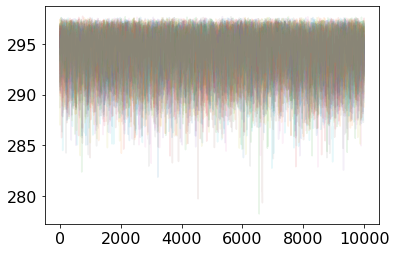

In [20]:
log_prob = sampler.get_log_prob()
for i in range(nwalkers):
    plt.plot(log_prob[:,i],alpha=0.1)


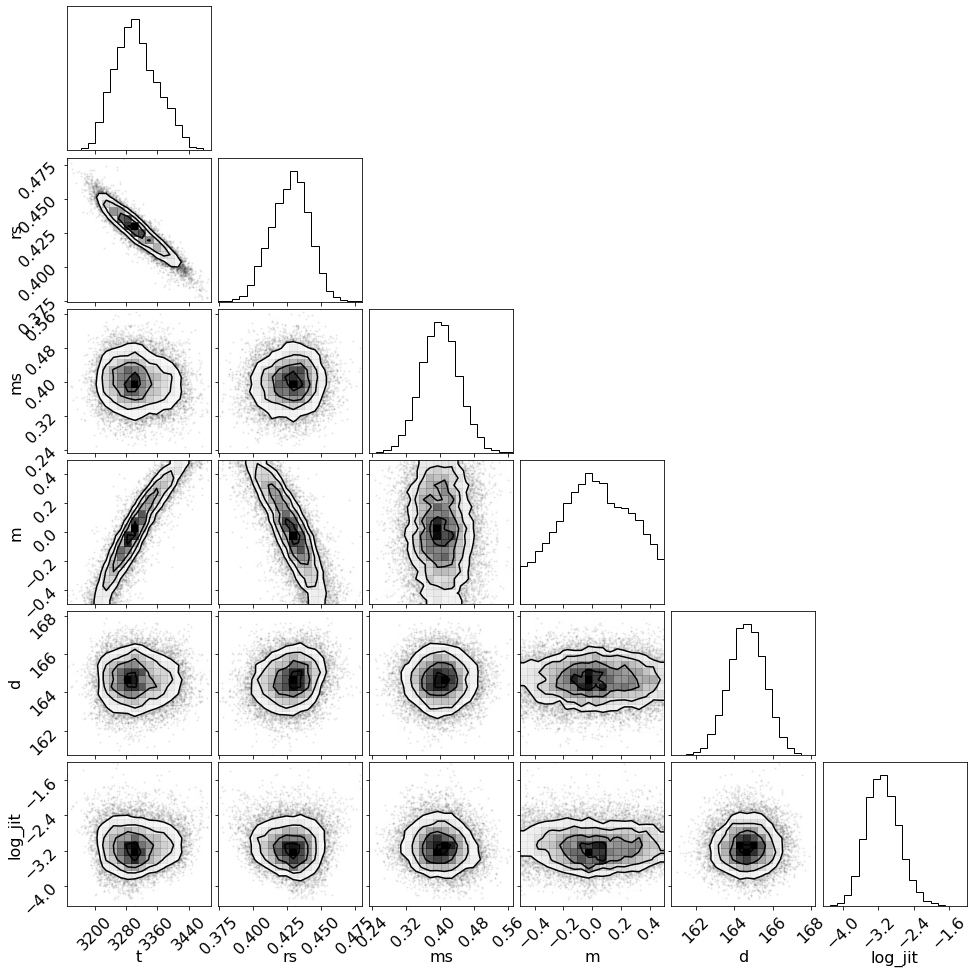

In [21]:
n0=5000
log_prob = sampler.get_log_prob(flat=True, discard=n0, thin=10)
samples = sampler.get_chain(flat=True, discard=n0, thin=10)


mask = (log_prob > 0)
#& (samples[:,10] > 0.001)
    
plt.rcParams['font.size']=16

fig = corner.corner(samples[:,:][mask],\
                    labels=['t', 'rs', 'ms', 'm', 'd', 'log_jit'])


In [22]:
# for BHAC15
sig_B = 5.670374419e-8 # W m^-2 K^-4
Lsun = 3.839e26 # W
Tsun = (Lsun/(4*np.pi*sig_B*Rsun**2))**0.25
#print(Tsun)
Msun = 1.9891e33 # g


Teff = samples[:,0]
Rs = samples[:,1]
Ms = samples[:,2]
feh = samples[:,3]
d = samples[:,4]
log_jit = samples[:,5]
jit = np.exp(log_jit)


Ms = ms_prior + np.random.randn(len(Rs))*ms_prior_err
logg = np.log10( GMsun*Ms / (Rs*Rsun)**2 *100 ) # cgs

val = lc_func.percentile(jit)
print('jit = ${0:.4f}\ ^{{+{1:.4f}}}_{{-{2:.4f}}}$'.format(val[0], val[2]-val[0], val[0]-val[1]))


val = lc_func.percentile(Teff)
print('Teff = ${0:.0f}\ ^{{+{1:.0f}}}_{{-{2:.0f}}}$'.format(val[0], val[2]-val[0], val[0]-val[1]))

val = lc_func.percentile(feh)
print('[Fe/H] = ${0:.3f}\ ^{{+{1:.3f}}}_{{-{2:.3f}}}$'.format(val[0], val[2]-val[0], val[0]-val[1]))

val = lc_func.percentile(Rs)
print('Rs = ${0:.4f}\ ^{{+{1:.4f}}}_{{-{2:.4f}}}$'.format(val[0], val[2]-val[0], val[0]-val[1]))

val = lc_func.percentile(Ms)
print('Ms = ${0:.4f}\ ^{{+{1:.4f}}}_{{-{2:.4f}}}$'.format(val[0], val[2]-val[0], val[0]-val[1]))

val = lc_func.percentile(d)
print('d = ${0:.4f}\ ^{{+{1:.4f}}}_{{-{2:.4f}}}$'.format(val[0], val[2]-val[0], val[0]-val[1]))

val = lc_func.percentile(logg)
print('logg = ${0:.3f}\ ^{{+{1:.3f}}}_{{-{2:.3f}}}$'.format(val[0], val[2]-val[0], val[0]-val[1]))

rhos = (Ms*Msun)/(4/3*np.pi*(Rs*Rsun*1e2)**3) # g cm^-3
val = lc_func.percentile(rhos)
print('rhos (g cm^-3) = ${0:.1f}\ ^{{+{1:.1f}}}_{{-{2:.1f}}}$'.format(val[0], val[2]-val[0], val[0]-val[1]))

rhos = Ms/(Rs**3) # rho_sun
val = lc_func.percentile(rhos)
print('rhos (rho_sun) = ${0:.2f}\ ^{{+{1:.2f}}}_{{-{2:.2f}}}$'.format(val[0], val[2]-val[0], val[0]-val[1]))



logL = 2*np.log(Rs) + 4*(np.log(Teff)-np.log(Tsun))
L = np.exp(logL)
val = lc_func.percentile(L)
print('L (Lsun) = ${0:.5f}\ ^{{+{1:.5f}}}_{{-{2:.5f}}}$'.format(val[0], val[2]-val[0], val[0]-val[1]))



jit = $0.0443\ ^{+0.0214}_{-0.0133}$
Teff = $3302\ ^{+63}_{-51}$
[Fe/H] = $0.015\ ^{+0.279}_{-0.263}$
Rs = $0.4281\ ^{+0.0128}_{-0.0154}$
Ms = $0.3959\ ^{+0.0444}_{-0.0443}$
d = $164.6593\ ^{+0.9406}_{-0.9536}$
logg = $4.774\ ^{+0.055}_{-0.059}$
rhos (g cm^-3) = $7.1\ ^{+1.1}_{-1.0}$
rhos (rho_sun) = $5.06\ ^{+0.81}_{-0.71}$
L (Lsun) = $0.01960\ ^{+0.00044}_{-0.00045}$
